In [42]:
#Disabling warnings
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

#Importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from collections import defaultdict

pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings('ignore')

In [2]:
#Importing datasets
df_train = pd.read_csv('training_data.csv')
df_test = pd.read_csv('eval_data.csv')

In [3]:
# Converting the server timestamp into a real date
df_train['date'] = pd.to_datetime(df_train['server_timestamp_epoch_ms'],unit='ms')
df_test['date'] = pd.to_datetime(df_test['server_timestamp_epoch_ms'],unit='ms')

# 1. Pre-processing the sessions

In [4]:
# 1.1 sessionise product action based on session ID
def sessionise(df):
    df['product_action'] = df['product_action'].fillna('view')
    df = df.groupby('session_id_hash')['product_action'].agg(list).reset_index()
    return df
    
df_test1 = sessionise(df_test)
df_train1 = sessionise(df_train)

In [5]:
# Creating a temporary dataframe where the start and end time of a session are grouped by the session ID 
df_test2 =df_test.groupby('session_id_hash')['date'].agg(['min', 'max'])
df_train2 =df_train.groupby('session_id_hash')['date'].agg(['min', 'max'])

# Merging the 2 dataframes on session ID
df_test = pd.merge(df_test1, df_test2, how='left', on='session_id_hash')
df_train = pd.merge(df_train1, df_train2, how='left', on='session_id_hash')

In [6]:
# 1.2 select sessions with at least one add-to-cart (1pt)
df_train = df_train[df_train['product_action'].apply(lambda x: 'add' in x)]
df_test = df_test[df_test['product_action'].apply(lambda x: 'add' in x)]

In [7]:
# 1.3 add class labels: treat purchase as the positive class (1pt)
df_train['purchase'] = np.where(df_train.product_action.map(set(['purchase']).issubset), 1, 0)
df_test['purchase'] = np.where(df_test.product_action.map(set(['purchase']).issubset), 1, 0)

In [8]:
# 1.4 cut purchase sessions to the last event before the first purchase (1pt)
df_train['product_action'] = df_train['product_action'].map(lambda x: x[0:(x.index('purchase'))] if 'purchase' in x else x)
df_test['product_action'] = df_test['product_action'].map(lambda x: x[0:(x.index('purchase'))] if 'purchase' in x else x)

In [9]:
# 1.5 remove sessions shorter than 5 and longer than 155 clicks (1pt)
def resize(df):
    df['count'] = df['product_action'].astype(str).str.split(pat = ',').str.len()
    df = df[df['count'].apply(lambda x: x > 5 and x < 155)]
    df = df.drop(['count'], axis=1)
    return df

df_train = resize(df_train)
df_test = resize(df_test)

In [10]:
# 1.6 symbolise actions (1pt)
#{'view': 1, 'detail': 2, 'add': 3, 'remove': 4}
def symbolise(x):
    l = []
    for word in x:
        if word == 'view':
            l.append(1)
        if word == 'detail':
            l.append(2)
        if word == 'add':
            l.append(3)
        if word == 'remove':
            l.append(4)  
    return l

df_train['product_action'] =  df_train['product_action'].apply(symbolise)
df_test['product_action'] =  df_test['product_action'].apply(symbolise)

In [11]:
# Make datasplit; 5/10/15 after add to cart
def cut_after(x, n):
    # if 3 (add to cart) not in list return None
    if 3 not in x:
        return None
    
    out = []
    index = x.index(3) + n + 1
    
    #check if n(5, 10, 15) indexes after 3 is possible, if not return whole list
    if index > len(x):
        return None
    
    #return list untill n after 3
    for i in range(index):
        out.append(x[i])
    
    return out


def cut_df(df):
    df['action_5']  = df['product_action'].apply(lambda x: cut_after(x, 5))
    df['action_10'] = df['product_action'].apply(lambda x: cut_after(x, 10))
    df['action_15'] = df['product_action'].apply(lambda x: cut_after(x, 15))
    
    df_5 = df[['action_5', 'min', 'max', 'purchase']]
    df_10 = df[['action_10','min', 'max', 'purchase']]
    df_15 = df[['action_15', 'min', 'max','purchase']]
    
    # remove rows with no data, the rows with fewer then 5, 10 or 15 instences
    df_5 = df_5.dropna()
    df_10 = df_10.dropna()
    df_15 = df_15.dropna()

    df_5 = df_5.rename(columns   = {'action_5':'action'})
    df_10 = df_10.rename(columns = {'action_10':'action'})
    df_15 = df_15.rename(columns = {'action_15':'action'})
    
    return df_5, df_10, df_15

df_train_5, df_train_10, df_train_15 = cut_df(df_train)
df_test_5, df_test_10, df_test_15 = cut_df(df_test)

In [12]:
# Adding day of the week column to the dataframe
# Monday =0, Tuesday=1, Wednesday=2,Thursday =3,  Friday=4 ,  Saturday =5, Sunday =6)
# It is better to use numbers that represent the day in the week or else we will have to create dummy variables later
df_train_5['day_of_week'] = df_train_5['min'].dt.dayofweek
df_train_10['day_of_week'] = df_train_10['min'].dt.dayofweek
df_train_15['day_of_week'] = df_train_15['min'].dt.dayofweek
df_test_5['day_of_week'] = df_test_5['min'].dt.dayofweek
df_test_10['day_of_week'] = df_test_10['min'].dt.dayofweek
df_test_15['day_of_week'] = df_test_5['min'].dt.dayofweek

In [13]:
# Calculating how long the sessions are in minutes and creating a new column
df_train_5['session_in_minutes']= (df_train_5['max']-df_train_5['min'] ).astype('timedelta64[m]')
df_train_10['session_in_minutes']= (df_train_10['max']-df_train_10['min'] ).astype('timedelta64[m]')
df_train_15['session_in_minutes']= (df_train_15['max']-df_train_15['min'] ).astype('timedelta64[m]')

df_test_5['session_in_minutes']= (df_test_5['max']-df_test_5['min'] ).astype('timedelta64[m]')
df_test_10['session_in_minutes']= (df_test_10['max']-df_test_10['min'] ).astype('timedelta64[m]')
df_test_15['session_in_minutes']= (df_test_15['max']-df_test_15['min'] ).astype('timedelta64[m]')

# 2. Oracle Model

In [14]:
# 2.1 Oracle score for 5 after add to cart

# Splitting symbolise and labels
symbolise_5 =  df_test_5['action']
labels_5 = df_test_5['purchase']

# Looping through sessions in the evaluation set and storing a dictionary which
# maps session, label, and how often that session is found with that label 
d = defaultdict(lambda: defaultdict(int))
for session, label in zip(symbolise_5, labels_5):
    d[str(tuple(session))][label] += 1

# For each label in a session it counts the number of purchase and number of browsing
# and in the end it normalizes it
oracle = {}
for session in d.keys():
    n_buy, n_ws = 0, 0
    for label in d[session].keys():
        if label:
            n_buy += d[session][label]
        else:
            n_ws += d[session][label]
    oracle[session] = n_buy / (n_buy + n_ws)

# Assigning the oracle scores per session to a list
session_oracle = list()

for i in df_test_5['action']:
    session_oracle.append(oracle[str(tuple(i))])

# Converting the oracle score to integers
oracle_probs = [round(num) for num in session_oracle]

# Computing 5 after add to cart f1 score
oracle_labels_5 = oracle_probs
labels_test_5 = df_test_5['purchase']

print('f1 for Oracle Model 5 after add to cart:', metrics.f1_score(oracle_labels_5, labels_test_5))

f1 for Oracle Model 5 after add to cart: 0.6669442131557036


In [15]:
# 2.2 Oracle score for 10 after add to cart

# Splitting symbolise and labels
symbolise_10 =  df_test_10['action']
labels_10 = df_test_10['purchase']

# Looping through sessions in the evaluation set and storing a dictionary which
# maps session, label, and how often that session is found with that label 
d = defaultdict(lambda: defaultdict(int))
for session, label in zip(symbolise_10, labels_10):
    d[str(tuple(session))][label] += 1

# For each label in a session it counts the number of purchase and number of browsing
# and in the end it normalizes it
oracle = {}
for session in d.keys():
    n_buy, n_ws = 0, 0
    for label in d[session].keys():
        if label:
            n_buy += d[session][label]
        else:
            n_ws += d[session][label]
    oracle[session] = n_buy / (n_buy + n_ws)

# Assigning the oracle scores per session to a list
session_oracle = list()

for i in df_test_10['action']:
    session_oracle.append(oracle[str(tuple(i))])

# Converting the oracle score to integers
oracle_probs = [round(num) for num in session_oracle]

# Computing 10 after add to cart f1 score
oracle_labels_10 = oracle_probs
labels_test_10 = df_test_10['purchase']

print('f1 for Oracle Model 10 after add to cart:', metrics.f1_score(oracle_labels_10, labels_test_10))

f1 for Oracle Model 10 after add to cart: 0.8967468175388967


In [16]:
# 2.3 Oracle score for 15 after add to cart

# Splitting symbolise and labels
symbolise_15 =  df_test_15['action']
labels_15 = df_test_15['purchase']

# Looping through sessions in the evaluation set and storing a dictionary which
# maps session, label, and how often that session is found with that label 
d = defaultdict(lambda: defaultdict(int))
for session, label in zip(symbolise_15, labels_15):
    d[str(tuple(session))][label] += 1

# For each label in a session it counts the number of purchase and number of browsing
# and in the end it normalizes it
oracle = {}
for session in d.keys():
    n_buy, n_ws = 0, 0
    for label in d[session].keys():
        if label:
            n_buy += d[session][label]
        else:
            n_ws += d[session][label]
    oracle[session] = n_buy / (n_buy + n_ws)

# Assigning the oracle scores per session to a list
session_oracle = list()

for i in df_test_15['action']:
    session_oracle.append(oracle[str(tuple(i))])

# Converting the oracle score to integers
oracle_probs = [round(num) for num in session_oracle]

# Computing 15 after add to cart f1 score
oracle_labels_15 = oracle_probs
labels_test_15 = df_test_15['purchase']

print('f1 for Oracle Model 15 after add to cart:', metrics.f1_score(oracle_labels_15, labels_test_15))

f1 for Oracle Model 15 after add to cart: 0.9697089685210849


In [17]:
# Function for making ngrams
def ngram_featurizer(session, n):
    session = ['#'] + session + ['+']
    ngrams = [tuple(session[i:i+n]) for i in range(len(session)-n+1)]
    
    return ngrams
    

def encode_sessions(sessions, n, mapping=None):
    if not mapping:
        all_ngrams = set()
        for session in sessions:
            all_ngrams = all_ngrams.union(set(ngram_featurizer(session, n)))
    
        mapping = {ngram: i for i, ngram in enumerate(all_ngrams)}
    
    X = np.zeros((len(sessions), len(mapping)))
    for i, session in enumerate(sessions):
        for ngram in ngram_featurizer(session, n):
            try:
                X[i, mapping[ngram]] += 1
            except KeyError:
                pass
    
    return X, mapping

# 3. Baseline

In [18]:
# 3.1 Naïve Bayes, order 3, 5 clicks post add-to-cart
#Make split
sessions_train = list(df_train_5['action'])
sessions_test = list(df_test_5['action'])
labels_train = list(df_train_5['purchase'])
labels_test = list(df_test_5['purchase'])

#make n-grams
Xtrain, mapping = encode_sessions(sessions_train, 3)
Xtest, _ = encode_sessions(sessions_test, 3, mapping=mapping)

#Train model
NB = MultinomialNB(alpha=1, fit_prior=True)
NB.fit(Xtrain,labels_train)
bayes_predictions = NB.predict(Xtest)

#print result
print('f1 for 5 after add to cart:', metrics.f1_score(labels_test, bayes_predictions))

f1 for 5 after add to cart: 0.3030984763268228


In [19]:
# 3.2 Naïve Bayes, order 3, 10 clicks post add-to-cart
#Make split
sessions_train = list(df_train_10['action'])
sessions_test = list(df_test_10['action'])
labels_train = list(df_train_10['purchase'])
labels_test = list(df_test_10['purchase'])

#make n-grams
Xtrain, mapping = encode_sessions(sessions_train, 3)
Xtest, _ = encode_sessions(sessions_test, 3, mapping=mapping)

#Train model
NB = MultinomialNB()
NB.fit(Xtrain,labels_train)
bayes_predictions = NB.predict(Xtest)

#print result
print('f1 for 10 after add to cart:', metrics.f1_score(labels_test, bayes_predictions))

f1 for 10 after add to cart: 0.35261707988980723


In [20]:
# 3.3 Naïve Bayes, order 3, 15 clicks post add-to-cart
#Make split
sessions_train = list(df_train_15['action'])
sessions_test = list(df_test_15['action'])
labels_train = list(df_train_15['purchase'])
labels_test = list(df_test_15['purchase'])

#make n-grams
Xtrain, mapping = encode_sessions(sessions_train, 3)
Xtest, _ = encode_sessions(sessions_test, 3, mapping=mapping)

#Train model
NB = MultinomialNB()
NB.fit(Xtrain,labels_train)
bayes_predictions = NB.predict(Xtest)

#print result
print('f1 for 15 after add to cart:', metrics.f1_score(labels_test, bayes_predictions))

f1 for 15 after add to cart: 0.3675298804780877


# 4. Implementing a better model: Random Forest

In [21]:
# 4.1 Random Forest, order 3, 5 clicks after add to cart
# Make split
sessions_train = list(df_train_5['action'])
sessions_test = list(df_test_5['action'])
labels_train = list(df_train_5['purchase'])
labels_test = list(df_test_5['purchase'])

# make n-grams
Xtrain, mapping = encode_sessions(sessions_train, 3)
Xtest, _ = encode_sessions(sessions_test, 3, mapping=mapping)

# adding the sessions in minutes and weekday column
Xtrain = pd.DataFrame(Xtrain)
Xtrain[['day_of_week', 'session_in_minutes']] = df_train_5[['day_of_week', 'session_in_minutes']].values
Xtest = pd.DataFrame(Xtest)
Xtest[['day_of_week', 'session_in_minutes']] = df_test_5[['day_of_week', 'session_in_minutes']].values

# Train model
clf = RandomForestClassifier(n_estimators = 10, max_depth = 10, max_features = "auto", class_weight = "balanced")
clf.fit(Xtrain, labels_train)
forest_predictions = clf.predict(Xtest)

# Print result
print("f1 for 5 after add to cart with extra columns:", metrics.f1_score(labels_test, forest_predictions))

f1 for 5 after add to cart with extra columns: 0.4221723044397463


In [22]:
# 4.2 Random Forest, order 3, 10 clicks after add to cart
# Make split
sessions_train = list(df_train_10['action'])
sessions_test = list(df_test_10['action'])
labels_train = list(df_train_10['purchase'])
labels_test = list(df_test_10['purchase'])

# make n-grams
Xtrain, mapping = encode_sessions(sessions_train, 3)
Xtest, _ = encode_sessions(sessions_test, 3, mapping=mapping)

# adding the sessions in minutes and weekday column
Xtrain = pd.DataFrame(Xtrain)
Xtrain[['day_of_week', 'session_in_minutes']] = df_train_10[['day_of_week', 'session_in_minutes']].values
Xtest = pd.DataFrame(Xtest)
Xtest[['day_of_week', 'session_in_minutes']] = df_test_10[['day_of_week', 'session_in_minutes']].values

# Train model
clf = RandomForestClassifier(n_estimators = 10, max_depth = 10, max_features = "auto", class_weight = "balanced")
clf.fit(Xtrain, labels_train)
forest_predictions = clf.predict(Xtest)

# Print result
print("f1 for 10 after add to cart with extra columns:", metrics.f1_score(labels_test, forest_predictions))

f1 for 10 after add to cart with extra columns: 0.4196702989661916


In [23]:
# 4.3 Random Forest, order 3, 15 clicks after add to cart
# Make split
sessions_train = list(df_train_15['action'])
sessions_test = list(df_test_15['action'])
labels_train = list(df_train_15['purchase'])
labels_test = list(df_test_15['purchase'])

# make n-grams
Xtrain, mapping = encode_sessions(sessions_train, 3)
Xtest, _ = encode_sessions(sessions_test, 3, mapping=mapping)

# adding the sessions in minutes and weekday column
Xtrain = pd.DataFrame(Xtrain)
Xtrain[['day_of_week', 'session_in_minutes']] = df_train_15[['day_of_week', 'session_in_minutes']].values
Xtest = pd.DataFrame(Xtest)
Xtest[['day_of_week', 'session_in_minutes']] = df_test_15[['day_of_week', 'session_in_minutes']].values

# Train model
clf = RandomForestClassifier(n_estimators = 10, max_depth = 10, max_features = "auto", class_weight = "balanced")
clf.fit(Xtrain, labels_train)
forest_predictions = clf.predict(Xtest)

# Print result
print("f1 for 15 after add to cart with extra columns:", metrics.f1_score(labels_test, forest_predictions))

f1 for 15 after add to cart with extra columns: 0.4260309278350516


# 5. Error analysis

First of all, there is a clear class imbalance in both the training and testing set:



In [28]:
majority_train = np.mean(labels_train)
majority_test = np.mean(labels_test)

print("The proportion of 'purchase' sessions in the training data: {} and test data: {}".format(majority_train, majority_test))

The proportion of 'purchase' sessions in the training data: 0.2602045433975925 and test data: 0.20377952755905512


Regardless of this, both models from task 4 are a bit too quick to classify a session as a "purchase" session, at least when compared to the actual proportion of the "purchase" class in the data. Between the two, the (expanded) Naive Bayes classifier is more likely than the Random Forest to assign "0" to a session, i.e. to classify it as a "browsing" session:

In [29]:
print("The proportion of 'purchase' sessions predicted by the NB classifier: {} and the Random Forest: {}".format(np.mean(bayes_predictions), np.mean(forest_predictions)))

The proportion of 'purchase' sessions predicted by the NB classifier: 0.31803149606299214 and the Random Forest: 0.407244094488189


A confusion matrix for each model's predictions shows this in more detail.

While their precision values are more or less equal, the Random Forest was able to single out more of the TPs (true positives, or actual "purchase" sessions) than the Naive Bayes model. This means we get a much higher recall rate for the Random Forest than for Naive Bayes, at the cost of also generating a higher number of FPs (false positives): 

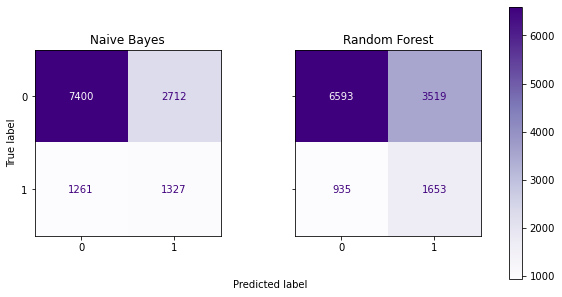

In [30]:
models = {"Naive Bayes" : bayes_predictions, 
          "Random Forest" : forest_predictions}
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey='row')

for i, (key, predictions) in enumerate(models.items()):
    y_pred = predictions
    cm = confusion_matrix(labels_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=set(labels_test))
    disp.plot(ax=axes[i], cmap= 'Purples')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

fig.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

fig.colorbar(disp.im_, ax=axes)
plt.show()

This ultimately results in a slightly higher F1 score for the Random Forest when compared to the Naive Bayes model. 

*   So... is one of the models better than the other? 

Identifying potential customers is arguably more important for a company's marketing strategy than missing out on potential buyers for the sake of avoiding false positives. More specifically: it does not matter much if your advertising campaigns also reach some random shoppers, as long as it reaches a significant portion of the intended target audience. As such, preference should be given to the predictions of the Random Forest classifier.

### Analysing feature importance: how did the models come to their predictions?

To help us find out, we first assess the importance of the features in our Random Forest classifier based on Mean Decrease in Impurity (MDI). The feature importances are computed as 
the mean and standard deviation of the accumulation of impurity decrease within each tree, as it splits into more branches:


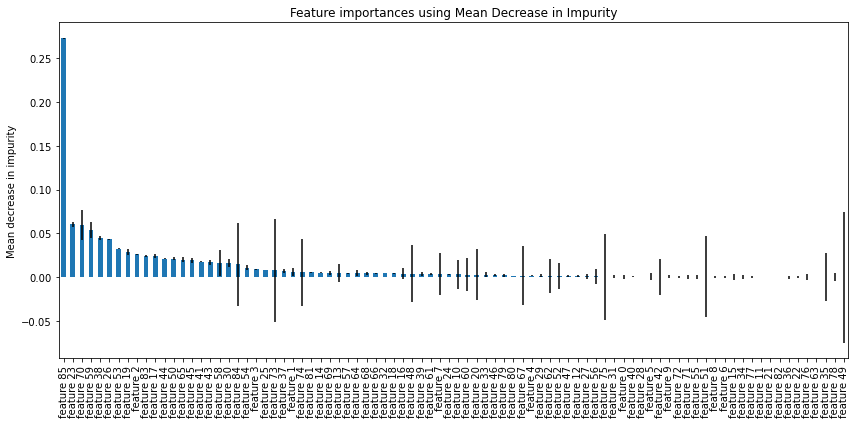

In [31]:
""" Feature importances are provided by the fitted attribute feature_importances, then plotted. """

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

feature_names = [f"feature {i}" for i in range(Xtrain.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)

# Plotting the feature ranking

fig, ax = plt.subplots()
forest_importances.sort_values(ascending=False).plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using Mean Decrease in Impurity")
ax.set_ylabel("Mean decrease in impurity")
fig.set_size_inches(12, 6)
fig.tight_layout()

# From: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

We use a function to get the n-grams of interest from the mapping. The mapping that is used is the one generated on the dataframe with sessions clipped at 15 clicks post add-to-cart:

In [32]:
# Function to get a selected n-gram from the mapping (the most recent mapping is used, so at 15 clicks post add-to-cart)
def get_key(val):
    for key, value in mapping.items():
         if val == value:
                return key
 
    return "key doesn't exist in mapping"

# Change the index to get the top n most important features in the model
top_n = forest_importances.sort_values(ascending=False)[:5]
print("Most important features by mean decrease in impurity:\n{}".format(top_n))

view_ngrams = []

for i in top_n.index:
    view_ngrams.append(i.lstrip("feature "))

for i in view_ngrams:
    print("n-gram: {}".format(get_key(int(i))))

Most important features by mean decrease in impurity:
feature 85    0.272606
feature 23    0.060477
feature 70    0.059313
feature 59    0.053969
feature 38    0.044745
dtype: float64
n-gram: key doesn't exist in mapping
n-gram: (4, 1, 4)
n-gram: (2, 1, 1)
n-gram: (1, 2, 1)
n-gram: (1, 1, 1)


In [33]:
# Change the index to get the top n LEAST important features in the model
top_n = forest_importances.sort_values(ascending=True)[:5]
print("Least important features by mean decrease in impurity:\n{}".format(top_n))

view_ngrams = []

for i in top_n.index:
    view_ngrams.append(i.lstrip("feature "))

for i in view_ngrams:
    print("n-gram: {}".format(get_key(int(i))))

Least important features by mean decrease in impurity:
feature 35    0.000000
feature 78    0.000000
feature 49    0.000000
feature 63    0.000000
feature 76    0.000066
dtype: float64
n-gram: (4, 1, 3)
n-gram: (3, 4, 2)
n-gram: ('#', 2, 2)
n-gram: ('#', 4, 2)
n-gram: ('#', 3, 2)


From the above, it appears that one feature is much more conclusive than all the others. This feature with number "85" does not exist in the mapping of n-grams to factors, as this is not an n-gram but the session length in minutes for each session.

A more general way to determine feature importance is through feature permutation, or "leave-one-out". This overcomes limitations of the impurity-based feature importance, as it does not have a bias towards high-cardinality features and can be computed on a left-out test set.

*   Spoiler: this method comes up with exactly the same "most conclusive" features as the above method based on MDI:

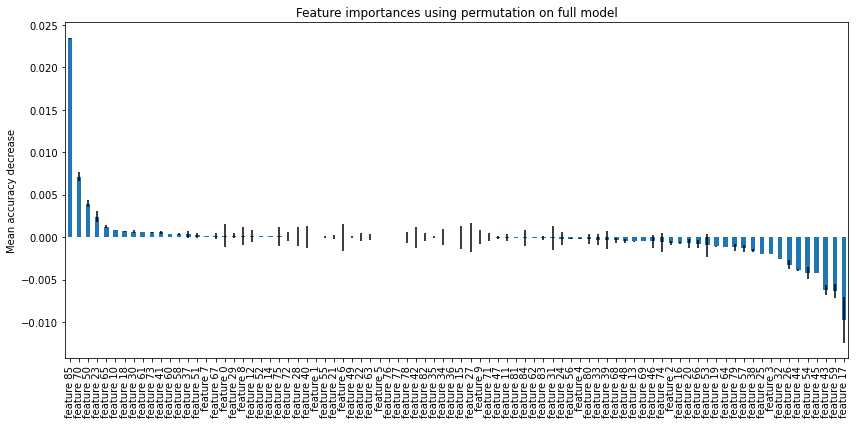

In [34]:
""" Feature analysis based on feature permutation. """

result = permutation_importance(
    clf, Xtest.values, labels_test, n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=feature_names)
feature_names = [f"feature {i}" for i in range(Xtest.shape[1])]

# Plotting the feature ranking
fig, ax = plt.subplots()
forest_importances.sort_values(ascending=False).plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.set_size_inches(12, 6)
fig.tight_layout()
plt.show()

# From: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [35]:
# Change the index to get the top n MOST important features in the model
top_n = forest_importances.sort_values(ascending=False)[:5]
print("Most important features based on feature permutation:\n{}".format(top_n))

view_ngrams = []

for i in top_n.index:
    view_ngrams.append(i.lstrip("feature "))

for i in view_ngrams:
    print("n-gram: {}".format(get_key(int(i))))

Most important features based on feature permutation:
feature 85    0.023386
feature 70    0.007118
feature 50    0.003953
feature 23    0.002433
feature 65    0.001228
dtype: float64
n-gram: key doesn't exist in mapping
n-gram: (2, 1, 1)
n-gram: (1, 2, '+')
n-gram: (4, 1, 4)
n-gram: (2, 1, '+')


In [36]:
# Change the index to get the top n LEAST important features in the model
top_n = forest_importances.sort_values(ascending=True)[:5]
print("Least important features based on feature permutation:\n{}".format(top_n))

view_ngrams = []

for i in top_n.index:
    view_ngrams.append(i.lstrip("feature "))

for i in view_ngrams:
    print("n-gram: {}".format(get_key(int(i))))

Least important features based on feature permutation:
feature 17   -0.009724
feature 59   -0.006315
feature 43   -0.006213
feature 45   -0.004244
feature 54   -0.004236
dtype: float64
n-gram: (3, 1, 1)
n-gram: (1, 2, 1)
n-gram: (1, 2, 2)
n-gram: (3, 4, 1)
n-gram: (2, 2, 1)


Contrary to the selection of most useful features, the *least* useful features produced by the two different approaches vary. The MDI approach selects some beginning- or end-of-session n-grams as being among the least telling features in the Random Forest model, which the permutation method does not do. 

*   Based on the results above, there does not necessarily seem to be an obvious sign of what a 3-gram needs to look like in order to be useful or not. Strikingly, some of the most and least useful n-grams are in fact quite similar: compare most useful (1, 2, 1) or (1, 1, 2) with least useful (1, 1, 1) or (2, 1, 2).

Feature importance through permutations can also be determined for the Naive Bayes model:

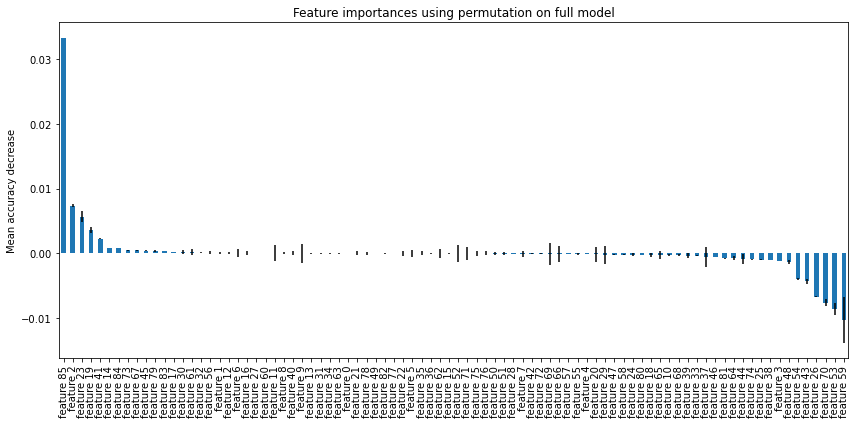

In [37]:
result = permutation_importance(
    NB, Xtest.values, labels_test, n_repeats=10, random_state=42, n_jobs=2)
bayes_importances = pd.Series(result.importances_mean, index=feature_names)
feature_names = [f"feature {i}" for i in range(Xtest.shape[1])]

# Plotting the feature ranking
fig, ax = plt.subplots()
bayes_importances.sort_values(ascending=False).plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.set_size_inches(12, 6)
fig.tight_layout()
plt.show()

In [38]:
top_n = bayes_importances.sort_values(ascending=False)[:5]
print("Most important features based on feature permutation:\n{}".format(top_n))

view_ngrams = []

for i in top_n.index:
    view_ngrams.append(i.lstrip("feature "))

for i in view_ngrams:
    print("n-gram: {}".format(get_key(int(i))))

Most important features based on feature permutation:
feature 85    0.033323
feature 2     0.007394
feature 23    0.005654
feature 19    0.003630
feature 41    0.002244
dtype: float64
n-gram: key doesn't exist in mapping
n-gram: (4, 4, 4)
n-gram: (4, 1, 4)
n-gram: (1, 4, 4)
n-gram: (4, 4, 1)


In [39]:
top_n = bayes_importances.sort_values(ascending=True)[:5]
print("Least important features based on feature permutation:\n{}".format(top_n))

view_ngrams = []

for i in top_n.index:
    view_ngrams.append(i.lstrip("feature "))

for i in view_ngrams:
    print("n-gram: {}".format(get_key(int(i))))

Least important features based on feature permutation:
feature 59   -0.010299
feature 53   -0.008575
feature 70   -0.007661
feature 26   -0.006685
feature 43   -0.004346
dtype: float64
n-gram: (1, 2, 1)
n-gram: (2, 1, 2)
n-gram: (2, 1, 1)
n-gram: (1, 1, 2)
n-gram: (1, 2, 2)


Interestingly, the Naive Bayes model does seem to make a clear distinction: an n-gram that contains two or more '4' - 'remove from cart' actions is sure to end up in the top 5 most useful three-grams. At the same time, n-grams solely made up out of '1' - 'view', and '2' - 'detail' actions end up all the way on the bottom of the list.

Perhaps the action of discarding some items from one's cart is indicative of a decided customer before checkout, and thus increases the probability of the session ending in a purchase? Naive Bayes agrees, the Random Forest not so much.

### Session length

Both models agree on the usefulness of the session length in minutes. Is session length really decisive in whether a given session is going to end in a purchase or not?

The density plots show a similar distribution of sessions by duration for both of our classes, with a steeper curve for class "0". This would suggest there is some difference in session length between groups, although the higher frequency of class "0" in the data may distort our perspective:

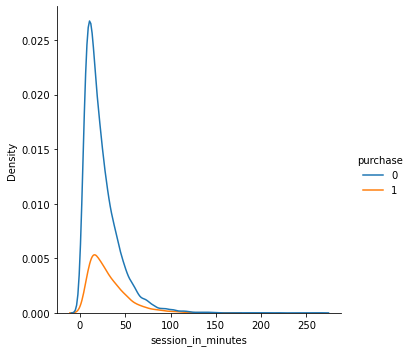

In [40]:
sns.displot(data=df_test_15, x='session_in_minutes', kind='kde', hue='purchase')

The difference is more visible when looking at the histograms of both classes: "browsing" sessions tend to lie on the shorter end of the spectrum, while successful "purchase" sessions do indeed tend to go on a bit more frequently:

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

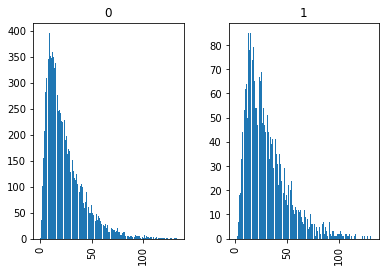

In [41]:
dwell = df_test_15['session_in_minutes']
dwell.hist(by=df_test_15['purchase'], bins = 150, range=(dwell.min(), 0.5*dwell.max()))